In [1]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from armadata import ARMAVolumeDataset
from statsmodels.stats.outliers_influence import variance_inflation_factor
from arch import arch_model
import statsmodels.api as sm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
train_dataset = ARMAVolumeDataset(dt.datetime(2022, 9, 30), dt.datetime(2023, 5, 8))
val_dataset = ARMAVolumeDataset(dt.datetime(2023, 5, 9), dt.datetime(2023, 7, 19))
test_dataset = ARMAVolumeDataset(dt.datetime(2023, 7, 20), dt.datetime(2023, 9, 30))

In [3]:
train_data = train_dataset.process_data()
val_data = val_dataset.process_data()
test_data = test_dataset.process_data()

[INFO] Saved processed dataset to: /Users/Samantha/Downloads/PyTorch-Code-ARMA-ARMA_LSTM-main/processed_arma_volume_dataset.csv
[INFO] Saved processed dataset to: /Users/Samantha/Downloads/PyTorch-Code-ARMA-ARMA_LSTM-main/processed_arma_volume_dataset.csv
[INFO] Saved processed dataset to: /Users/Samantha/Downloads/PyTorch-Code-ARMA-ARMA_LSTM-main/processed_arma_volume_dataset.csv


In [4]:
train_series = pd.Series(train_data['log_diff_volume'].values)
val_series = pd.Series(val_data['log_diff_volume'].values)
test_series = pd.Series(test_data['log_diff_volume'].values)

In [5]:
train_diff = train_series.values
val_diff = val_series.values
test_diff = test_series.values

In [6]:
#STATIONARY, AUTOCORR TESTS
adf_result = adfuller(train_diff)
print("\n[ADF Test - train_diff]")
print(f"ADF Statistic: {adf_result[0]:.6f}")
print(f"p-value: {adf_result[1]:.6f}")


[ADF Test - train_diff]
ADF Statistic: -25.271467
p-value: 0.000000


In [7]:
lb_test = acorr_ljungbox(train_diff, lags=[20], return_df=True)
p_value = lb_test['lb_pvalue'].iloc[0]
print(f"Ljung-Box p-value at lag 20: {p_value:.6f}")

Ljung-Box p-value at lag 20: 0.000000


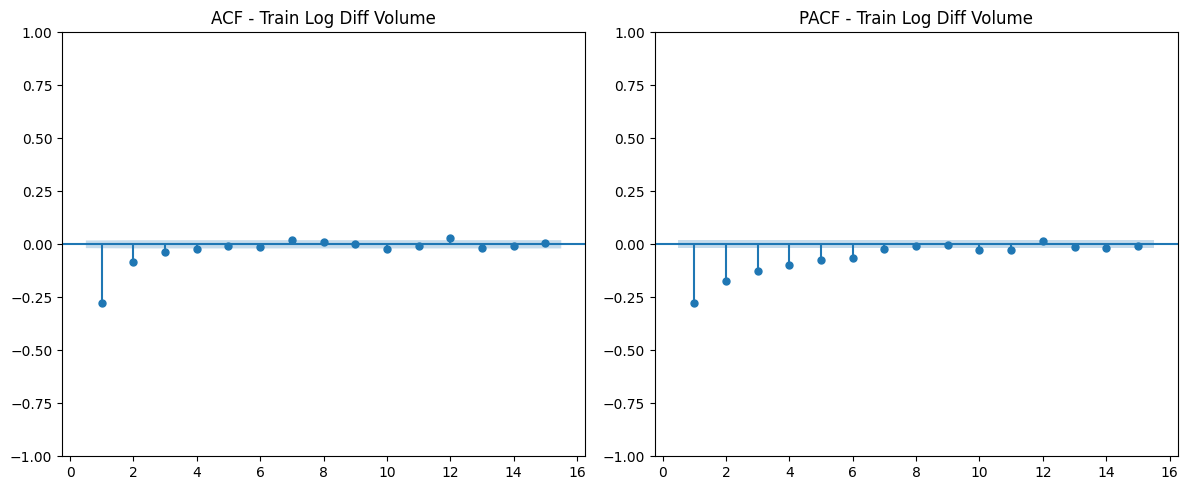

In [8]:
#ACF AND PACF GRAPHS
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(train_series, lags=15, zero=False, ax=plt.gca())
plt.title("ACF - Train Log Diff Volume")
plt.subplot(1, 2, 2)
plot_pacf(train_series, lags=15, zero=False, ax=plt.gca())
plt.title("PACF - Train Log Diff Volume")
plt.tight_layout()
plt.show()

In [9]:
#CHOOSE THE BEST ARIMAX MODEL
orders = {}
for q in range(1, 3):
    orders[f"MA({q})"] = (0, 0, q)

for p in range(1, 3):
    orders[f"AR({p})"] = (p, 0, 0)

for p in range(1, 3):
    for q in range(1, 3):
        orders[f"ARMA({p},{q})"] = (p, 0, q)

for p in range(1, 3):
    for d in range(1, 3):
        for q in range(1, 3):
            orders[f"ARIMA({p},{d},{q})"] = (p, d, q)


In [10]:
orders

{'MA(1)': (0, 0, 1),
 'MA(2)': (0, 0, 2),
 'AR(1)': (1, 0, 0),
 'AR(2)': (2, 0, 0),
 'ARMA(1,1)': (1, 0, 1),
 'ARMA(1,2)': (1, 0, 2),
 'ARMA(2,1)': (2, 0, 1),
 'ARMA(2,2)': (2, 0, 2),
 'ARIMA(1,1,1)': (1, 1, 1),
 'ARIMA(1,1,2)': (1, 1, 2),
 'ARIMA(1,2,1)': (1, 2, 1),
 'ARIMA(1,2,2)': (1, 2, 2),
 'ARIMA(2,1,1)': (2, 1, 1),
 'ARIMA(2,1,2)': (2, 1, 2),
 'ARIMA(2,2,1)': (2, 2, 1),
 'ARIMA(2,2,2)': (2, 2, 2)}

In [11]:
results = []
best_rmse = np.inf
best_model = None

In [12]:
for name, order in orders.items():
    
    model = ARIMA(train_series, order=order)
    model_fit = model.fit()
    
    val_series_aligned = pd.Series(val_series.values, index=pd.RangeIndex(start=len(train_series), stop=len(train_series) + len(val_series)))
    updated_model = model_fit.append(val_series_aligned)
    
    forecast_series = updated_model.predict(start=len(train_series), end=len(train_series) + len(val_series) - 1, dynamic=False)
    forecast = np.nan_to_num(forecast_series.values, nan=0.0)
    
    rmse = np.sqrt(mean_squared_error(val_diff, forecast))
    results.append({'model': name, 'order': order, 'RMSE': rmse})

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as 

In [13]:
results_df = pd.DataFrame(results).sort_values('RMSE')
print("\n[MODEL COMPARISON SUMMARY]")
print(results_df.to_string(index=False))


[MODEL COMPARISON SUMMARY]
       model     order         RMSE
   ARMA(2,1) (2, 0, 1) 4.904227e-01
   ARMA(1,2) (1, 0, 2) 4.904348e-01
ARIMA(2,1,2) (2, 1, 2) 4.905184e-01
   ARMA(2,2) (2, 0, 2) 4.906159e-01
   ARMA(1,1) (1, 0, 1) 4.906396e-01
ARIMA(1,1,2) (1, 1, 2) 4.906614e-01
       MA(2) (0, 0, 2) 4.915789e-01
       MA(1) (0, 0, 1) 4.939477e-01
       AR(2) (2, 0, 0) 5.007903e-01
ARIMA(2,1,1) (2, 1, 1) 5.008115e-01
       AR(1) (1, 0, 0) 5.075855e-01
ARIMA(1,1,1) (1, 1, 1) 5.076031e-01
ARIMA(1,2,2) (1, 2, 2) 5.088422e-01
ARIMA(2,2,1) (2, 2, 1) 6.367639e-01
ARIMA(1,2,1) (1, 2, 1) 6.969463e-01
ARIMA(2,2,2) (2, 2, 2) 2.791049e+07


In [14]:
#TO CHECK USING VIF LATER
sing_exog_vars = ['log_return', 'relative_open', 'relative_high', 'relative_low', 'relative_close']

In [15]:
#CHECK VIF OF EXOG
vif_data = train_data[sing_exog_vars].dropna()
X_vif = sm.add_constant(vif_data)
vif_results = pd.DataFrame()
vif_results["Variable"] = X_vif.columns
vif_results["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("\n[VIF CHECK]")
print(vif_results.to_string(index=False))


[VIF CHECK]
      Variable      VIF
         const 0.000000
    log_return 2.339801
 relative_open 2.048584
 relative_high      inf
  relative_low      inf
relative_close 1.888704


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [16]:
#TO TEST EXOG COMBINATIONS AFTER VIF
exog_vars = [
    'log_return', 'relative_open', 'relative_close',
    ['log_return', 'relative_open'],
    ['log_return', 'relative_close'],
    ['relative_open', 'relative_close'],
    ['log_return', 'relative_open', 'relative_close']
]

In [17]:
#CHECK RMSE OF EXOG COMBINATIONS ON VAL
results_exog = []
best_rmse_exog = np.inf
best_var = "log_return"

In [18]:
for var in exog_vars:
    cols = var if isinstance(var, list) else [var]
    name = "+".join(cols)

    exog_train = train_data[cols].iloc[:len(train_series)].values
    exog_val = val_data[cols].iloc[:len(val_series)].values

    model = ARIMA(train_series, order=(2,0,1), exog=exog_train)
    model_fit = model.fit()

    val_indices = pd.RangeIndex(start=len(train_series), stop=len(train_series) + len(val_series))
    val_series_clean = pd.Series(val_series.values, index=val_indices)
    exog_val_clean = pd.DataFrame(exog_val, index=val_indices)

    updated_model = model_fit.append(val_series_clean, exog=exog_val_clean)
    forecast_series = updated_model.predict(start=val_indices[0], end=val_indices[-1], exog=exog_val_clean)
    forecast = np.nan_to_num(forecast_series.values, nan=0.0)

    rmse = np.sqrt(mean_squared_error(val_diff, forecast))
    results_exog.append({'exog_set': name, 'RMSE': rmse})


In [19]:
exog_results_df = pd.DataFrame(results_exog).sort_values('RMSE').drop_duplicates(subset='RMSE')
print("\n[EXOGENOUS SELECTION SUMMARY]")
print(exog_results_df.to_string(index=False))


[EXOGENOUS SELECTION SUMMARY]
                               exog_set     RMSE
log_return+relative_open+relative_close 0.489787
              log_return+relative_close 0.489793
           relative_open+relative_close 0.490025
                             log_return 0.490131
                          relative_open 0.490154
               log_return+relative_open 0.490210
                         relative_close 0.490427


In [20]:
best_exog_cols = best_var.split('+')
exog_train_best = train_data[best_exog_cols].iloc[:len(train_series)].values
final_arimax_for_diag = ARIMA(train_series, order=(2,0,1), exog=exog_train_best).fit()
train_residuals = final_arimax_for_diag.resid

In [21]:
#CHECK FOR GARCH EFFECTS
arch_lm_result = het_arch(train_residuals)
print("\n[ARCH-LM Test - train_residuals]")
print(f"ARCH-LM Statistic: {arch_lm_result[0]:.6f}")
print(f"p-value: {arch_lm_result[1]:.6f}")


[ARCH-LM Test - train_residuals]
ARCH-LM Statistic: 825.127051
p-value: 0.000000


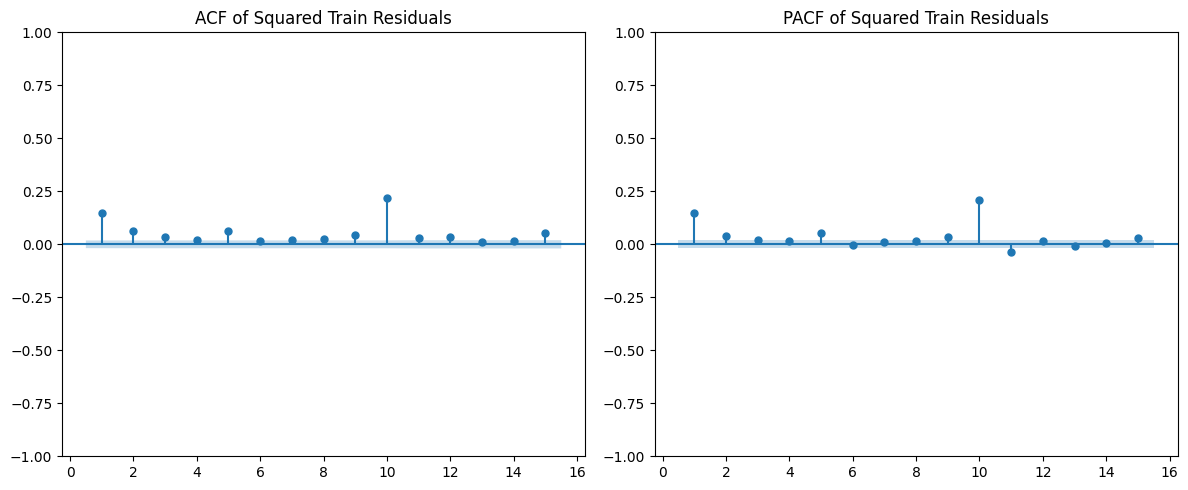

In [22]:
#CHECK CANDIDATE LAGS FOR GARCH
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(np.square(train_residuals), lags=15, zero=False, ax=plt.gca())
plt.title("ACF of Squared Train Residuals")
plt.subplot(1, 2, 2)
plot_pacf(np.square(train_residuals), lags=15, zero=False, ax=plt.gca())
plt.title("PACF of Squared Train Residuals")
plt.tight_layout()
plt.show()

In [23]:
#GET VAL RESIDUALS USING ARMAX FINAL
exog_val_best = val_data[best_exog_cols].iloc[:len(val_series)].values

val_indices = pd.RangeIndex(start=len(train_series), stop=len(train_series) + len(val_series))
val_series_clean = pd.Series(val_series.values, index=val_indices)
exog_val_clean = pd.DataFrame(exog_val_best, index=val_indices)

updated_model = final_arimax_for_diag.append(val_series_clean, exog=exog_val_clean)

val_forecast_mean = updated_model.predict(start=val_indices[0], end=val_indices[-1], exog=exog_val_clean)

val_residuals = val_diff - forecast_series.values

In [24]:
#FIND THE BEST GARCH MODEL
arch_results = []
best_rmse_vol = np.inf
best_params_vol = None

In [25]:
#FORECAST THE MEAN
final_var = best_var.split('+')
exog_train = train_data[final_var].iloc[:len(train_series)].values
exog_test = test_data[final_var].iloc[:len(test_series)].values
arimax_fit = ARIMA(train_series, order=(2,0,1), exog=exog_train).fit()

test_dates = test_data.index[-len(test_diff):]
test_indices = pd.RangeIndex(start=len(train_series), stop=len(train_series) + len(test_diff))
exog_test_df = pd.DataFrame(exog_test, index=test_indices)

updated_arimax = arimax_fit.append(pd.Series(test_diff, index=test_indices), exog=exog_test_df)
mean_forecast = updated_arimax.predict(start=test_indices[0], end=test_indices[-1], exog=exog_test_df).values

In [26]:
actual_values = np.asarray(test_diff).flatten()
predicted_values = np.asarray(mean_forecast).flatten()

mse_mean_only = np.mean((actual_values - predicted_values)**2)
rmse_mean_only = np.sqrt(mse_mean_only)

print(f"Standard ARMA Mean-Only RMSE: {rmse_mean_only:.6f}")

Standard ARMA Mean-Only RMSE: 0.407511


In [27]:
garch_model = arch_model(train_residuals, vol='GARCH', p=1, q=1, mean="Zero")
garch_fitted = garch_model.fit(disp="off")

In [28]:
#GARCH(1,1) bootstrap
#https://github.com/bashtage/arch/blob/main/arch/tests/univariate/test_variance_forecasting.py
B, H = 1000, len(val_diff)
params = garch_fitted.params
omega = params['omega']
alpha = params['alpha[1]']
beta  = params['beta[1]']
gamma = params.get('gamma[1]', 0)

std_resids = (train_residuals / garch_fitted.conditional_volatility).dropna().values
std_shocks = np.random.choice(std_resids, size=(B, H))
sigma2_paths = np.zeros((B, H))
shocks = np.zeros((B, H))

last_sigma2 = garch_fitted.conditional_volatility.iloc[-1]**2
last_resid  = train_residuals.iloc[-1]

for t in range(H):
    prev_v = last_sigma2 if t == 0 else sigma2_paths[:, t-1]
    prev_r = last_resid  if t == 0 else shocks[:, t-1]

    leverage = gamma * (prev_r**2) * (prev_r < 0)
    sigma2_t = omega + alpha * (prev_r**2) + leverage + beta * prev_v
    sigma2_paths[:, t] = np.maximum(sigma2_t, 1e-10)
    shocks[:, t] = np.sqrt(sigma2_paths[:, t]) * std_shocks[:, t]

combined_garch = val_forecast_mean.values.reshape(1, -1) + shocks
rmse_garch_val = np.sqrt(np.mean((combined_garch - val_diff.reshape(1, -1))**2, axis=1)).mean()

print(f"Validation ARMAX x GARCH RMSE: {rmse_garch_val:.6f}")

Validation ARMAX x GARCH RMSE: 0.615195


In [29]:
egarch_model = arch_model(train_residuals, vol='EGARCH', p=1, q=1, mean="Zero")
egarch_fitted = egarch_model.fit(disp="off")

In [30]:
#EGARCH(1,1) BOOTSTRAP
#https://github.com/bashtage/arch/blob/main/arch/tests/univariate/test_variance_forecasting.py

B, H = 1000, len(val_diff)
p = egarch_fitted.params
sqrt2pi = np.sqrt(2 / np.pi)

std_resids = (train_residuals / egarch_fitted.conditional_volatility).dropna().values
std_shocks = np.random.choice(std_resids, size=(B, H))

log_var_paths = np.zeros((B, H))
shocks = np.zeros((B, H))

last_log_var = np.log(egarch_fitted.conditional_volatility.iloc[-1]**2)
last_z = train_residuals.iloc[-1] / egarch_fitted.conditional_volatility.iloc[-1]

for t in range(H):
    prev_log = last_log_var if t == 0 else log_var_paths[:, t-1]
    prev_z_val = last_z if t == 0 else std_shocks[:, t-1]
    
    log_var_t = (p['omega'] + 
                 p['alpha[1]'] * (np.abs(prev_z_val) - sqrt2pi) + 
                 p.get('gamma[1]', 0) * prev_z_val + 
                 p['beta[1]'] * prev_log)
    
    log_var_paths[:, t] = np.clip(log_var_t, -20, 20)
    shocks[:, t] = np.sqrt(np.exp(log_var_paths[:, t])) * std_shocks[:, t]

combined_egarch_val = val_forecast_mean.values.reshape(1, -1) + shocks
rmse_egarch_val = np.sqrt(np.mean((combined_egarch_val - val_diff.reshape(1, -1))**2, axis=1)).mean()

print(f"Validation ARMAX x EGARCH RMSE: {rmse_egarch_val:.6f}")


Validation ARMAX x EGARCH RMSE: 0.615808


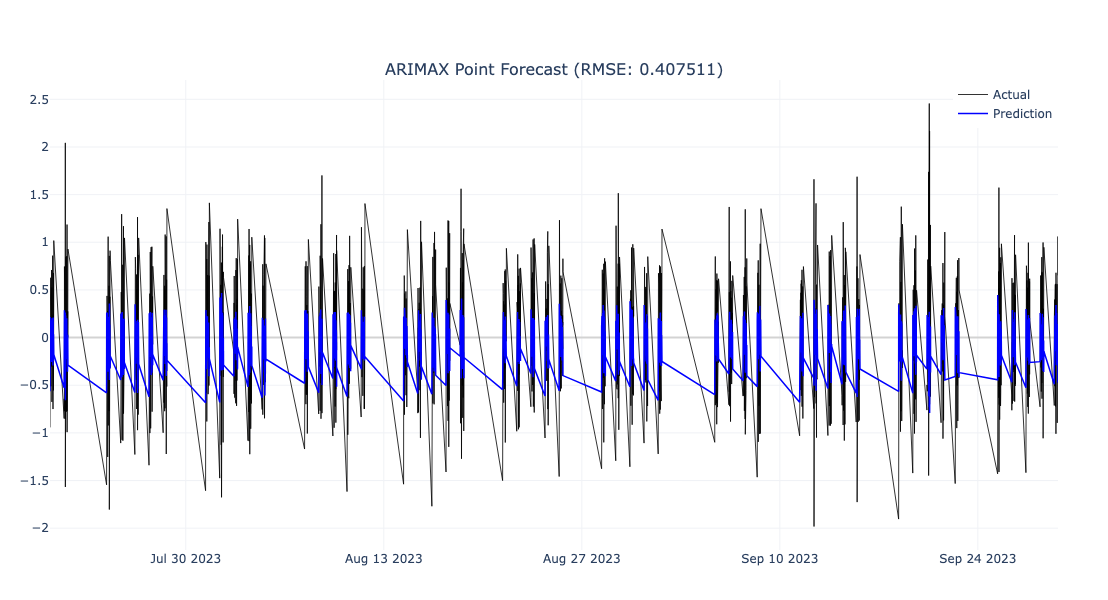

In [31]:
# PLOT THE RESULTS
fig = make_subplots(rows=1, cols=1, subplot_titles=[f"ARIMAX Point Forecast (RMSE: {rmse_mean_only:.6f})"])
fig.add_trace(go.Scatter(x=test_dates, y=test_diff, name="Actual", line=dict(color='black', width=1), opacity=0.8),row=1, col=1)
fig.add_trace(go.Scatter(x=test_dates, y=mean_forecast, name="Prediction", line=dict(color='blue', width=1.5)),row=1, col=1)

fig.update_layout(template="plotly_white", height=600, showlegend=True,legend=dict(orientation="v", yanchor="top", y=1, xanchor="right",x=1), margin=dict(l=50, r=50, t=80, b=50))

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#f0f2f6', tickformat='%b %d %Y')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#f0f2f6', zeroline=True, zerolinecolor='lightgrey')

fig.show()

In [32]:
B, H = 1000, len(test_diff)
params = garch_fitted.params
omega = params['omega']
alpha = params['alpha[1]']
beta  = params['beta[1]']
gamma = params.get('gamma[1]', 0)

std_resids = (train_residuals / garch_fitted.conditional_volatility).dropna().values
std_shocks = np.random.choice(std_resids, size=(B, H))
sigma2_paths = np.zeros((B, H))
shocks = np.zeros((B, H))

last_sigma2 = garch_fitted.conditional_volatility.iloc[-1]**2
last_resid  = train_residuals.iloc[-1]

for t in range(H):
    prev_v = last_sigma2 if t == 0 else sigma2_paths[:, t-1]
    prev_r = last_resid  if t == 0 else shocks[:, t-1]

    leverage = gamma * (prev_r**2) * (prev_r < 0)
    sigma2_t = omega + alpha * (prev_r**2) + leverage + beta * prev_v
    sigma2_paths[:, t] = np.maximum(sigma2_t, 1e-10)
    shocks[:, t] = np.sqrt(sigma2_paths[:, t]) * std_shocks[:, t]

combined_garch_test = mean_forecast.reshape(1, -1) + shocks
rmse_garch_test = np.sqrt(np.mean((combined_garch_test - test_diff.reshape(1, -1))**2, axis=1)).mean()

print(f"Test ARMAX RMSE: {rmse_mean_only:.6f}")
print(f"Test ARMAX x GARCH RMSE: {rmse_garch_test:.6f}")

Test ARMAX RMSE: 0.407511
Test ARMAX x GARCH RMSE: 0.551641
